### Super steps in langgraph's. What are they?

#### Every invocation of the "graph.invoke()" method is considered as a super step in langgraph. If you have an AI ChatBot application in langgraph, for every AI response, you would call "graph.invoke()". The reason it is important to know this is because we will see shortly how we can use langsmith to debug, checkpoint, and setup observability, and also how memory/resources etc are shared across super steps. Nodes that run in parallel are part of the same super step, while nodes that run sequentiall belong to separate super steps.

#### lets go to https://langsmith.com to setup a few keys and put it in our .env. In langsmith, you need to click on "setup tracing" and follow the prompts.

In [4]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, TypedDict
from dotenv import load_dotenv
import os
import requests
import gradio as gr
from IPython.display import display, Image, Markdown
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolNode, tools_condition


In [5]:
load_dotenv(override=True)

True

In [6]:
# You remember using the Serper web search tool before. Langchain community comes with a simple wrapper for that tool. We will
# use it and see the traces in langsmith.
from langchain_community.utilities import GoogleSerperAPIWrapper

serper = GoogleSerperAPIWrapper()
serper.run("What is the capital of India?")

'Delhi, officially the National Capital Territory (NCT) of Delhi, is a city and a union territory of India containing New Delhi, the capital of India. New Delhi, national capital of India. It is situated in the north-central part of the country on the west bank of the Yamuna River. noun the capital of India is a division of the old city of Delhi synonyms: Indian capital, New Delhi A Delhi B Mumbai C Calcutta D Agra लिखित उत्तर Verified by Experts The correct Answer is:A Delhi is the capital of India. If you are asked what the capital of India is, your answer will be New Delhi, which was settled by the British. There are 28 states and 8 Union territories in the country. Union Territories are administered by the President through an Administrator appointed by him/her. The capital of India is New Delhi, located in the north-central part of the country to the west of the Yamuna River. Calcutta (now Kolkata, the ... The National Capital Territory of Delhi serves as the capital of India. It 

In [13]:
### We will now turn this into a tool using a wrapper class Tool.
from langchain.agents import Tool

tool_serper_search = Tool(
    name="search",
    description="Use this tool to search the web for information",
    func=serper.run,
)

# the standard way of calling and LLM or tool is to use the invoke method.
tool_serper_search.invoke("What is the capital of India?")



'Delhi, officially the National Capital Territory (NCT) of Delhi, is a city and a union territory of India containing New Delhi, the capital of India. New Delhi, national capital of India. It is situated in the north-central part of the country on the west bank of the Yamuna River. noun the capital of India is a division of the old city of Delhi synonyms: Indian capital, New Delhi A Delhi B Mumbai C Calcutta D Agra लिखित उत्तर Verified by Experts The correct Answer is:A Delhi is the capital of India. If you are asked what the capital of India is, your answer will be New Delhi, which was settled by the British. There are 28 states and 8 Union territories in the country. Union Territories are administered by the President through an Administrator appointed by him/her. The capital of India is New Delhi, located in the north-central part of the country to the west of the Yamuna River. Calcutta (now Kolkata, the ... The National Capital Territory of Delhi serves as the capital of India. It 

In [14]:
### Lets now wrap Pushover API in a tool.
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = f"https://api.pushover.net/1/messages.json"

def push(text: str):
    """send a push notification to the user"""
    requests.post(pushover_url, data={"token": pushover_token, "user": pushover_user, "message": text})

tool_pushover = Tool(
    name="send_push_notification",
    description="Use this tool to send a push notification to the user",
    func=push,
)

tool_pushover.invoke("Hello, this is a test push notification")

In [15]:
tools = [tool_serper_search, tool_pushover]

#### At this point, you shoud revisit lab_4.ipynb to understand how LLM handle tool calls and result. For every tool, you had to create an ugly json having keys like name, description, parameters to the tool function. You would then pass the tools to the agent as part of your prompt.

#### If agent decides to use a tool, it would return a finish_reason of "tools", which your code handles. and then calls the appropriate tool and then returns the result to the agent in another prompt.

### all that we will achieve here with langgraph.

In [16]:
# Lets begin with the usual State, graph_builder, nodes & edge creation and graph compilation. We will add special Tool nodes and conditional edges as you will see.
class State(TypedDict): # we could have used class State(pydantic.BaseModel) as well.
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [17]:
## Create your agent.
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)  ## Very easy way of generating the boilerplate json and making the tools available to the agent as part of the prompt.

In [ ]:
# create a chatbot node. Just like in the last lab.
def chatbot_node(old_state: State) -> State:
    response = llm_with_tools.invoke(old_state['messages'])
    new_state = State(messages=[response])
    return new_state

graph_builder.add_node("chatbot", chatbot_node)
graph_builder.add_node("tools", ToolNode(tools=tools)) 

# This is important. You are saying that "tools" is a special Tool Node, A Tool Node looks at the agent response from an agent and if the finish_reason is tool call, it will handle
# the tool call for you. After that we must add an edge from the "tools" node back to the "chatbot" node.

In [ ]:
graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END) # this is anyway added implicitly by langgraph.

In [ ]:
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
def chat(user_input: str, history):
    message = {"role": "user", "content": user_input} # this is the message we will give to the graph.
    messages = [message]
    state = State(messages=messages)
    result = graph.invoke(state)
    return result["messages"][-1].content

gr.ChatInterface(chat, type="messages").launch()

# Ask the agent to send you a push notification with the current USD/GBP exchange rate.

### Lets know discuss Memory. We have a class MemorySaver in langgraph.checkpoint.memory module for holding data in memory (i.e. in RAM, not a DB or file or anything). We can use this memory object across multiple iterations (super steps) of our graph. The best point of langgraph is that it allows you to get the state of your graph at any point in history and continue a new invocation of the graph from that point. Langgraph officially calls it time travel. Lets see it in action.

In [18]:
from langgraph.checkpoint.memory import MemorySaver

In [19]:
memory = MemorySaver()

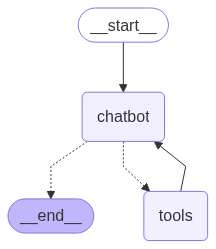

In [20]:
# all the steps as before.
# Steps 1 and 2
graph_builder = StateGraph(State)

# Step 3
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=memory) # Note the change here.
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
config = {"configurable": {"thread_id": "1"}} # config is a dictionary of configurable fields. example thread_id is a configurable field.
# thread_id means the thread id of the conversation. not a system thread id. so thread_id 1 and 2 are different conversations.

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='Hi there!', additional_kwargs={}, response_metadata={}, id='778ca37e-cbbd-4d18-ba54-dc05050077bd')]}
{'messages': [HumanMessage(content='Hi there!', additional_kwargs={}, response_metadata={}, id='778ca37e-cbbd-4d18-ba54-dc05050077bd'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 90, 'total_tokens': 100, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BltgqP2jnHEuGaH0G6ans1mF7aE8B', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--271c8f3d-fe34-4eff-b34f-b1f972fce422-0', usage_metadata={'input_tokens': 90, 'output_tokens': 10, 'total_tokens': 100, 

In [23]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='Hi there!', additional_kwargs={}, response_metadata={}, id='778ca37e-cbbd-4d18-ba54-dc05050077bd'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 90, 'total_tokens': 100, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BltgqP2jnHEuGaH0G6ans1mF7aE8B', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--271c8f3d-fe34-4eff-b34f-b1f972fce422-0', usage_metadata={'input_tokens': 90, 'output_tokens': 10, 'total_tokens': 100, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanM

In [25]:
list(graph.get_state_history(config))

[StateSnapshot(values={'messages': [HumanMessage(content='Hi there!', additional_kwargs={}, response_metadata={}, id='778ca37e-cbbd-4d18-ba54-dc05050077bd'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 90, 'total_tokens': 100, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BltgqP2jnHEuGaH0G6ans1mF7aE8B', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--271c8f3d-fe34-4eff-b34f-b1f972fce422-0', usage_metadata={'input_tokens': 90, 'output_tokens': 10, 'total_tokens': 100, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), Human

### LangGraph gives you tools to set the state back to a prior point in time, to branch off:

```
config = {"configurable": {"thread_id": "1", "checkpoint_id": ...}}
graph.invoke(None, config=config)
```

And this allows you to build stable systems that can be recovered and rerun from any prior checkpoint.

In [26]:
# Now we will use to store memory to Sqlite3 database. instead of memory.
# the interface is really consistent.
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path="memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory = SqliteSaver(conn)

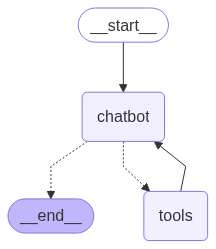

In [27]:
# Steps 1 and 2, exactly same as before.
graph_builder = StateGraph(State)

# Step 3
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=sql_memory)
display(Image(graph.get_graph().draw_mermaid_png()))
 

In [28]:
config = {"configurable": {"thread_id": "3"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

# try to use memory and tools both (like asking for an exchange rate and sending the rate as a push notification)

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.
